## Encoding categorical features with binary encoding, ordinal features with label encoding and boolean features with one hot encoding

In [1]:
! pip install category_encoders

     |████████████████████████████████| 81kB 8.6MB/s 


In [2]:
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import RegressorChain
import category_encoders as ce 
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import joblib
df2=joblib.load('/content/drive/MyDrive/pkls/data.pkl')

In [ ]:
# Removing extra features from which we created another features
df2.drop(['number','opened_at','sys_updated_at','sys_created_at','resolved_at', 'closed_at','resolved_time',
          'closed_time','opened_hour','opened_day','updated_hour','updated_day'],axis=1,inplace=True)

In [4]:
# One hot encoding of boolean features
def encode_categories(df,feature,num_of_cats):
    freq_ft=[val for val in df[feature].value_counts().sort_values(ascending=False).head(num_of_cats).index]
    for cat in freq_ft:
        df[feature+'_'+str(cat)]=np.where(df[feature]==cat,1,0)    

In [5]:
# Encoding booelan features with only one feature like replacing true or false of a feature with feature_true or feature_false ,here it contains wheter it is true or not
encode_categories(df2,'made_sla',1)
encode_categories(df2,'knowledge',1)
encode_categories(df2,'u_priority_confirmation',1)

In [6]:
# Train and test split the data
Y=df2[['resolved_time_log','closed_time_log']]
X=df2.drop(['resolved_time_log','closed_time_log'],axis=1,inplace=False)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 24)

In [7]:
df2.columns

Index(['number', 'incident_state', 'reassignment_count', 'reopen_count',
       'sys_mod_count', 'made_sla', 'caller_id', 'opened_at', 'sys_created_at',
       'sys_updated_at', 'impact', 'priority', 'knowledge',
       'u_priority_confirmation', 'closed_code', 'resolved_at', 'closed_at',
       'resolved_time', 'closed_time', 'opened_hour', 'opened_day',
       'updated_hour', 'updated_day', 'opened_hour_sin', 'opened_hour_cos',
       'opened_day_sin', 'opened_day_cos', 'updated_hour_sin',
       'updated_hour_cos', 'updated_day_sin', 'updated_day_cos',
       'updation_time', 'resolved_time_log', 'closed_time_log',
       'made_sla_True', 'knowledge_False', 'u_priority_confirmation_False'],
      dtype='object')

In [8]:
# Categorical features
df_cat_data_tr=x_train[['incident_state','caller_id','closed_code']]

df_cat_data_te=x_test[['incident_state','caller_id','closed_code']]

In [9]:
# Binary encoding of categorical features
encoder=ce.BinaryEncoder(df_cat_data_tr,return_df=True)

encoded_cats_tr=encoder.fit_transform(df_cat_data_tr) 
encoded_cats_te=encoder.transform(df_cat_data_te)

In [10]:
# Label encoding of impact feature
impact_enc1=LabelEncoder()
impact_tr=impact_enc1.fit_transform(x_train.impact)
impact_te=impact_enc1.transform(x_test.impact)

print('Shapes of train impact: {}  Shapes of test impact: {}'.format(impact_tr.shape,impact_te.shape))

Shapes of train impact: (89998,)  Shapes of test impact: (30000,)


In [11]:
x_train['impact_enc']=impact_tr
x_test['impact_enc']=impact_te

In [12]:
# Label encoding of priority feature
priority_enc=LabelEncoder()
priority_tr=priority_enc.fit_transform(x_train.priority)
priority_te=priority_enc.transform(x_test.priority)

print('Shapes of train impact: {}  Shapes of test impact: {}'.format(impact_tr.shape,impact_te.shape))

Shapes of train impact: (89998,)  Shapes of test impact: (30000,)


In [13]:
x_train['priority_enc']=priority_tr
x_test['priority_enc']=priority_te

In [14]:
# Merging binary encoded features with actual data frame
x_train1=x_train.merge(encoded_cats_tr,left_index=True, right_index=True)
x_test1=x_test.merge(encoded_cats_te,left_index=True, right_index=True)

In [15]:
# Removing the features which are encoded
x_train1.drop(['incident_state','caller_id','closed_code','impact','priority','made_sla','knowledge','u_priority_confirmation'],axis=1,inplace=True)
x_test1.drop(['incident_state','caller_id','closed_code','impact','priority','made_sla','knowledge','u_priority_confirmation'],axis=1,inplace=True)
x_train1.head()

,number,reassignment_count,reopen_count,sys_mod_count,opened_at,sys_created_at,sys_updated_at,resolved_at,closed_at,resolved_time,closed_time,opened_hour,opened_day,updated_hour,updated_day,opened_hour_sin,opened_hour_cos,opened_day_sin,opened_day_cos,updated_hour_sin,updated_hour_cos,updated_day_sin,updated_day_cos,updation_time,made_sla_True,knowledge_False,u_priority_confirmation_False,impact_enc,priority_enc,incident_state_0,incident_state_1,incident_state_2,incident_state_3,incident_state_4,caller_id_0,caller_id_1,caller_id_2,caller_id_3,caller_id_4,caller_id_5,caller_id_6,caller_id_7,caller_id_8,caller_id_9,caller_id_10,caller_id_11,caller_id_12,caller_id_13,closed_code_0,closed_code_1,closed_code_2,closed_code_3,closed_code_4,closed_code_5
49126,INC0011185,0,0,0,2016-03-24 15:33:00,Missing,2016-03-24 15:33:00,Missing,2016-03-29 15:59:00,434100.0,433560.0,15,4,15,4,-0.816970,-0.576680,-0.866025,-0.5,-0.816970,-0.576680,-0.866025,-0.5,0.0,1,1,1,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
44762,INC0010061,0,0,3,2016-03-22 14:24:00,2016-03-22 14:37:00,2016-03-24 12:09:00,2016-03-24 12:09:00,2016-03-29 12:59:00,164700.0,599700.0,14,2,12,4,-0.631088,-0.775711,0.866025,-0.5,-0.136167,-0.990686,-0.866025,-0.5,164700.0,1,1,0,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
53403,INC0012274,1,0,9,2016-03-29 07:18:00,2016-03-29 07:51:00,2016-04-05 10:07:00,2016-04-05 18:19:00,2016-04-10 18:59:00,644460.0,1078860.0,7,2,10,2,0.942261,-0.334880,0.866025,-0.5,0.398401,-0.917211,0.866025,-0.5,614940.0,1,1,1,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
26223,INC0005891,0,0,0,2016-03-11 10:47:00,Missing,2016-03-11 10:47:00,Missing,2016-03-24 18:51:00,434100.0,1152240.0,10,5,10,5,0.398401,-0.917211,-0.866025,0.5,0.398401,-0.917211,-0.866025,0.5,0.0,1,1,1,1,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
8999,INC0002080,7,0,23,2016-03-03 16:15:00,2016-03-03 16:23:00,2016-03-21 12:28:00,2016-03-21 12:28:00,2016-03-26 12:59:00,1541580.0,1975440.0,16,4,12,1,-0.942261,-0.334880,-0.866025,-0.5,-0.136167,-0.990686,0.866025,0.5,1541580.0,1,0,1,1,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1


In [16]:
def mse_scores(reg):
    ''' Prints Train and Test MSE of a model'''
    #Get predictions for the best estimator for train values
    pred_y=reg.best_estimator_.predict(x_train)
    
    #Tranform predicted values to original values for train data
    resolved_exp=np.expm1(pred_y[:,0])    
    closed_exp=np.expm1(pred_y[:,1])
    
    #Tranform actual log values to original values for train data
    resolved_y_train=np.expm1(y_train.iloc[:,0])
    closed_y_train=np.expm1(y_train.iloc[:,1])
    
    # MSE of resolved and closed times for train data
    resolved_mean_train_error=mean_squared_error(resolved_exp,resolved_y_train)
    closed_mean_train_error=mean_squared_error(closed_exp,closed_y_train)
    
    # MSE of resolved and closed times in minutes for train data
    print('Mean Train error:  {:.3f}   {:.3f}'.format(resolved_mean_train_error/60,closed_mean_train_error/60))

    #Get predictions for the best estimator for test values
    pred_y=reg.best_estimator_.predict(x_test)
    
    #Tranform predicted values to original values for test data
    resolved_exp=np.expm1(pred_y[:,0])
    closed_exp=np.expm1(pred_y[:,1]) 
    
    #Tranform actual log values to original values for test data
    resolved_y_test=np.expm1(y_test.iloc[:,0])   
    closed_y_test=np.expm1(y_test.iloc[:,1])
    
    # MSE of resolved and closed times for test data
    resolved_mean_test_error=mean_squared_error(resolved_exp,resolved_y_test)
    closed_mean_test_error=mean_squared_error(closed_exp,closed_y_test)
    
    # MSE of resolved and closed times in minutes for test data
    print('Mean Test error:   {:.3f}   {:.3f}'.format(resolved_mean_test_error/60,closed_mean_test_error/60))

In [ ]:
# Decision tree regressor
max_depth=[50,500,1000]
min_samples_split=[2,5,10,50,100]
reg= DecisionTreeRegressor()
param_dt={'max_depth':max_depth,'min_samples_split':min_samples_split}
grid_dt = GridSearchCV(estimator = reg,scoring='neg_root_mean_squared_error', param_grid = param_dt,
                                cv = 3, verbose=1,n_jobs = -1)
grid_dt.fit(x_train1, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   28.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [50, 500, 1000],
                         'min_samples_split': [2, 5, 10, 50, 100]},
             pre_dispatch='2*n_job

In [ ]:
grid_dt.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=50,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=100,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [17]:
# MSE of Decision Tree model
mse_scores(grid_dt)

Mean Train error:  3022.996   3123.581
Mean Test error:   3320.810   3392.072


In [ ]:
# Random Forest regressor
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
n_estimators = [x for x in range(20,200,20)]
min_samples_split = [2,5]
params_rf={'n_estimators':n_estimators,'min_samples_split':min_samples_split}
grid_rf = GridSearchCV(estimator = reg_rf,scoring='neg_root_mean_squared_error', param_grid = params_rf,
                                cv = 3, verbose=1,n_jobs = -1)
grid_rf.fit(x_train1, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 39.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
joblib.dump(grid_rf,'/content/drive/MyDrive/Approach3/rf.pkl')

['/content/drive/MyDrive/Approach3/rf.pkl']

In [18]:
mse_scores(grid_rf)

Mean Train error:  2127.350   1887.093
Mean Test error:   3021.787   2996.892


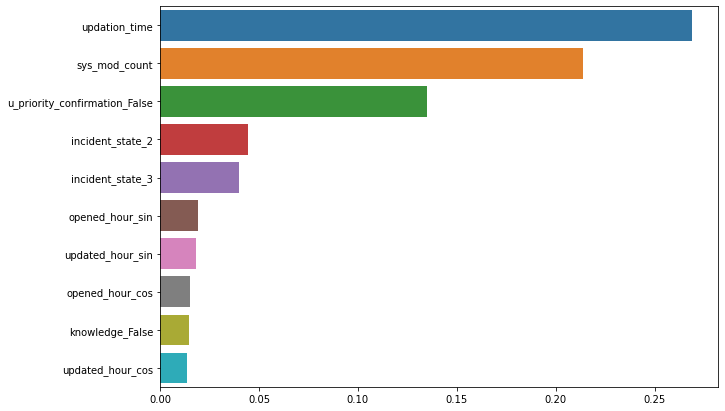

In [ ]:
# Feature importances from random forest model
import seaborn as sns
import matplotlib.pyplot as plt

feat_importances = pd.Series(grid_rf.best_estimator_.feature_importances_, index=x_train1.columns)
feat_importances=feat_importances.nlargest(10)

plt.subplots(figsize=(10,7))
sns.barplot(x=feat_importances.values,y=feat_importances.index)
plt.show()

In [ ]:
from xgboost.sklearn import XGBRegressor
xg = XGBRegressor(tree_method='gpu_hist', gpu_id=0,n_jobs = -1)
model_xg=RegressorChain(xg,order=[0,1])
prams={ 'base_estimator__learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],'base_estimator__n_estimators':[100,200,500,1000,2000]}
grid_xgb = GridSearchCV(model_xg,prams,cv = 3,scoring="neg_mean_squared_error",verbose=1)
grid_xgb.fit(x_train1, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[02:37:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[02:37:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:37:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:37:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:37:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  9.7min finished


[02:47:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:47:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, error_score=nan,
             estimator=RegressorChain(base_estimator=XGBRegressor(base_score=0.5,
                                                                  booster='gbtree',
                                                                  colsample_bylevel=1,
                                                                  colsample_bynode=1,
                                                                  colsample_bytree=1,
                                                                  gamma=0,
                                                                  gpu_id=0,
                                                                  importance_type='gain',
                                                                  learning_rate=0.1,
                                                                  max_delta_step=0,
                                                                  max_depth=3,
                                                  

In [19]:
# MSE of XGBoost model
mse_scores(grid_xgb)

Mean Train error:  3157.283   3351.122
Mean Test error:   9782.561   3401.063


In [24]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Resolved Time MSE","Closed Time MSE","Mean MSE"]
x.add_row(["Random Mean",126611.314,23906.956,75259.135])
x.add_row(["Decision Trees",3320.810, 3392.072,3356.441])
x.add_row(["Random Forest",3021.787 , 2996.892,3009.339])
x.add_row(["XG Boost", 9782.561 , 3401.063,6591.812])
print(x)

+----------------+-------------------+-----------------+-----------+
|     Model      | Resolved Time MSE | Closed Time MSE |  Mean MSE |
+----------------+-------------------+-----------------+-----------+
|  Random Mean   |     126611.314    |    23906.956    | 75259.135 |
| Decision Trees |      3320.81      |     3392.072    |  3356.441 |
| Random Forest  |      3021.787     |     2996.892    |  3009.339 |
|    XG Boost    |      9782.561     |     3401.063    |  6591.812 |
+----------------+-------------------+-----------------+-----------+
